### ปฏิบัติการครั้งที่ 9

ดาวน์โหลดข้อมูลอุณหภูมิสูงสุดรายวันปี 1998-2019 จาก link ข้างล่างนี้  
https://donlapark.pages.dev/229351/data/CM_temp.csv

1. เปลี่ยนจากข้อมูลรายวันให้เป็นข้อมูลค่าเฉลี่ยรายเดือน
2. จงแบ่งข้อมูลโดยให้ Test set เป็นข้อมูลของ 2 ปีสุดท้ายและ Training set เป็นข้อมูลที่เหลือ
3. ลองสร้างโมเดล SARIMA อันดับต่างๆ แล้วระบุโมเดลที่ดีที่สุด
4. จงแสดงแผนภาพของข้อมูลจริงกับข้อมูลที่ได้ในข้อ 3

In [1]:
!wget -O CM_temp.csv https://donlapark.pages.dev/229351/data/CM_temp.csv

--2025-09-23 15:01:56--  https://donlapark.pages.dev/229351/data/CM_temp.csv
Resolving donlapark.pages.dev (donlapark.pages.dev)... 172.66.44.200, 172.66.47.56, 2606:4700:310c::ac42:2f38, ...
Connecting to donlapark.pages.dev (donlapark.pages.dev)|172.66.44.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139473 (136K) [text/csv]
Saving to: ‘CM_temp.csv’

CM_temp.csv         100%[===================>] 136.20K  --.-KB/s    in 0.01s   

2025-09-23 15:01:56 (9.11 MB/s) - ‘CM_temp.csv’ saved [139473/139473]



In [3]:
!pip install pmdarima

  Using cached pmdarima-2.0.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
  Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached scipy-1.16.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (62 kB)
Using cached pmdarima-2.0.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 95.0 MB/s  0:00:00
Using cached scipy-1.16.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (35.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 114.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [pmdarima]


In [7]:
!pip uninstall -y numpy scipy scikit-learn statsmodels pmdarima
!pip install numpy==1.26.4
!pip install pmdarima

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scipy 1.16.2
Uninstalling scipy-1.16.2:
  Successfully uninstalled scipy-1.16.2
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: statsmodels 0.14.2
Uninstalling statsmodels-0.14.2:
  Successfully uninstalled statsmodels-0.14.2
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 82.5 MB/s  0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, which is not installed.
yellowbrick 1.5 requires scipy>=1.0.0, which is not installed.
pymc 5.25.1 requires scipy>=1.4.

  Using cached pmdarima-2.0.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 107, in _run_wrapper
    status = _inner_run()
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 98, in _inner_run
    return self.run(options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 71, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 393, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 9

In [4]:
# import module ที่ต้องใช้
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA


In [6]:
from datetime import datetime

def parser(dates):
  return datetime.strptime(dates, '%Y-%m-%d')

# parse_dates ชื่อของคอลัมน์ที่จะเปลี่ยนให้เป็น datetime
# index_col ชื่อของคอลัมน์ที่จะให้เป็น index
# date_parser ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
data = pd.read_csv('CM_temp.csv', parse_dates=['Date'],
                                        index_col='Date',
                                        date_format='%Y-%m-%d')

data.head()

,MaxTemp
Date,
1998-01-01,30.6
1998-01-02,32.0
1998-01-03,31.6
1998-01-04,32.1
1998-01-05,31.2


ข้อมูล (สมมติว่าชื่อ `data`) ที่ load มาเป็นข้อมูลรายวัน ทำการหาค่าเฉลี่ยรายเดือนด้วยคำสั่ง

In [7]:
y = data['MaxTemp'].resample("M").mean()

/tmp/ipython-input-3759875875.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = data['MaxTemp'].resample("M").mean()


In [8]:
def rmse(y_true,y_pred):
  # Inputs
  # y_true: actual value, y_pred: predicted values
  # Output: RMSE between y_true and y_pred
  return np.sqrt(np.mean(np.square(y_true-y_pred)))

In [9]:
train = y[:-24]
test = y[-24:]

print(test)

Date
2017-08-31    32.764516
2017-09-30    33.140000
2017-10-31    32.158065
2017-11-30    31.616667
2017-12-31    29.229032
2018-01-31    30.048387
2018-02-28    33.253571
2018-03-31    35.674194
2018-04-30    35.900000
2018-05-31    34.648387
2018-06-30    33.066667
2018-07-31    32.000000
2018-08-31    32.258065
2018-09-30    33.506667
2018-10-31    32.864516
2018-11-30    32.336667
2018-12-31    30.229032
2019-01-31    30.622581
2019-02-28    34.564286
2019-03-31    37.051613
2019-04-30    39.716667
2019-05-31    37.680645
2019-06-30    35.466667
2019-07-31    34.070968
Freq: ME, Name: MaxTemp, dtype: float64


In [10]:
best_model = pm.auto_arima(train, seasonal=True, m=12,
                           suppress_warnings=True, stepwise=True,
                           random_state=20,n_fits=50)

print(best_model.summary())

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  235
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -365.450
Date:                              Tue, 23 Sep 2025   AIC                            742.900
Time:                                      15:06:50   BIC                            763.632
Sample:                                  01-31-1998   HQIC                           751.259
                                       - 07-31-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6688      0.084      7.944      0.000       0.504       0.834
ma.L1         -1.26

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


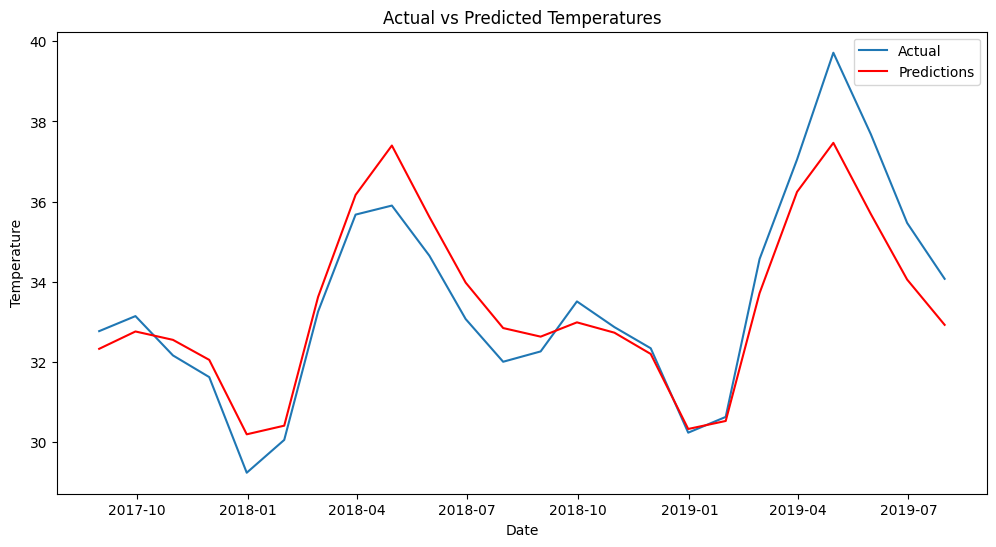

RMSE: 0.94


In [11]:
predictions = best_model.predict(n_periods=len(test))
predictions = pd.Series(predictions, index=test.index)
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Predictions', color='red')
plt.title('Actual vs Predicted Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

rmse_value = rmse(test, predictions)
print(f'RMSE: {rmse_value:.2f}')